In [ ]:
!pip install yfinance pandas_ta tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from google.colab import files

# --- 1. SETTINGS ---
COINS = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'DOGE-USD']
# To be safe and avoid Yahoo limits, we use 1 Year of Hourly data
PERIOD = "1y"
INTERVAL = "1h"

all_X = []
all_y = []

print(f"🚀 Starting Universal Training on {len(COINS)} coins...")

for coin in COINS:
    print(f"   Downloading {coin}...")
    try:
        df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)

        # --- FIX 1: FLATTEN COLUMNS (Standard) ---
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Backup cleanup
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

        # Check data
        if df.empty or len(df) < 100:
            print(f"   ⚠️ Skipping {coin} (Data empty)")
            continue

        # --- FIX 2: INDICATORS (The "Unbreakable" Logic) ---

        # 1. RSI
        df['RSI'] = df.ta.rsi(close=df['Close'], length=14)

        # 2. EMA Ratio
        df['EMA_20'] = df.ta.ema(close=df['Close'], length=20)
        df['EMA_50'] = df.ta.ema(close=df['Close'], length=50)
        df['EMA_Ratio'] = df['EMA_20'] / df['EMA_50']

        # 3. Bollinger Bands (NUCLEAR FIX for KeyError)
        bb = df.ta.bbands(close=df['Close'], length=20, std=2)

        if bb is not None and not bb.empty:
            # We rename the columns so we don't care what pandas_ta named them
            # Standard order is: Lower, Mid, Upper, Bandwidth, Percent
            bb.columns = ['Lower', 'Mid', 'Upper', 'Bandwidth', 'Percent']
            df['BB_Width'] = bb['Bandwidth']
        else:
            df['BB_Width'] = 0

        # 4. MACD
        macd = df.ta.macd(close=df['Close'], fast=12, slow=26, signal=9)
        if macd is not None and not macd.empty:
            # Rename MACD columns too just to be safe
            macd.columns = ['MACD', 'Histogram', 'Signal']
            df['MACD_Norm'] = macd['MACD'] / df['Close']
        else:
            df['MACD_Norm'] = 0

        # --- TARGET: 24h Swing Prediction ---
        df['Target'] = (df['Close'].shift(-24) > df['Close']).astype(int)
        df.dropna(inplace=True)

        # --- ADD TO LIST ---
        feature_cols = ['RSI', 'EMA_Ratio', 'BB_Width', 'MACD_Norm']

        if len(df) > 50:
            all_X.append(df[feature_cols].values)
            all_y.append(df['Target'].values)
            print(f"   ✅ {coin} processed: {len(df)} rows")
        else:
             print(f"   ⚠️ {coin} dropped (too few rows after cleaning)")

    except Exception as e:
        print(f"   ❌ Error processing {coin}: {e}")

# --- 4. COMBINE & TRAIN ---
if len(all_X) > 0:
    X = np.concatenate(all_X, axis=0)
    y = np.concatenate(all_y, axis=0)

    print(f"🔥 FINAL DATASET: {len(X)} samples total.")

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)

    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )

    model.save("universal_vibe_model.h5")
    joblib.dump(scaler, "scaler.pkl")
    files.download("universal_vibe_model.h5")
    files.download("scaler.pkl")
else:
    print("\n❌ NO DATA COLLECTED. Yahoo might be blocking or coins list is invalid.")

🚀 Starting Universal Training on 6 coins...


/tmp/ipython-input-4043482860.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)


   ✅ BTC-USD processed: 8556 rows


/tmp/ipython-input-4043482860.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)


   ✅ ETH-USD processed: 8556 rows


/tmp/ipython-input-4043482860.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)


   ✅ SOL-USD processed: 8556 rows


/tmp/ipython-input-4043482860.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)


   ✅ BNB-USD processed: 8556 rows


/tmp/ipython-input-4043482860.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)


   ✅ XRP-USD processed: 8556 rows


/tmp/ipython-input-4043482860.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(coin, period=PERIOD, interval=INTERVAL, progress=False)


   ✅ DOGE-USD processed: 8556 rows
🔥 FINAL DATASET: 51336 samples total.
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5200 - loss: 0.6953 - val_accuracy: 0.5204 - val_loss: 0.6910
Epoch 2/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5235 - loss: 0.6907 - val_accuracy: 0.5192 - val_loss: 0.6907
Epoch 3/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5231 - loss: 0.6896 - val_accuracy: 0.5224 - val_loss: 0.6897
Epoch 4/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5236 - loss: 0.6899 - val_accuracy: 0.5243 - val_loss: 0.6897
Epoch 5/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5260 - loss: 0.6884 - val_accuracy: 0.5401 - val_loss: 0.6883
Epoch 6/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5285 - loss: 0.6884 - val_accuracy: 0.5199 - val_loss: 0.6898
Epoch 7/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5280 - loss: 0.6882 - val_accuracy: 0.5178 - val_loss: 0.6897
Epoch 8/100
642/642 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5310 - loss: 0.6882 - val_accuracy: 0.5294

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


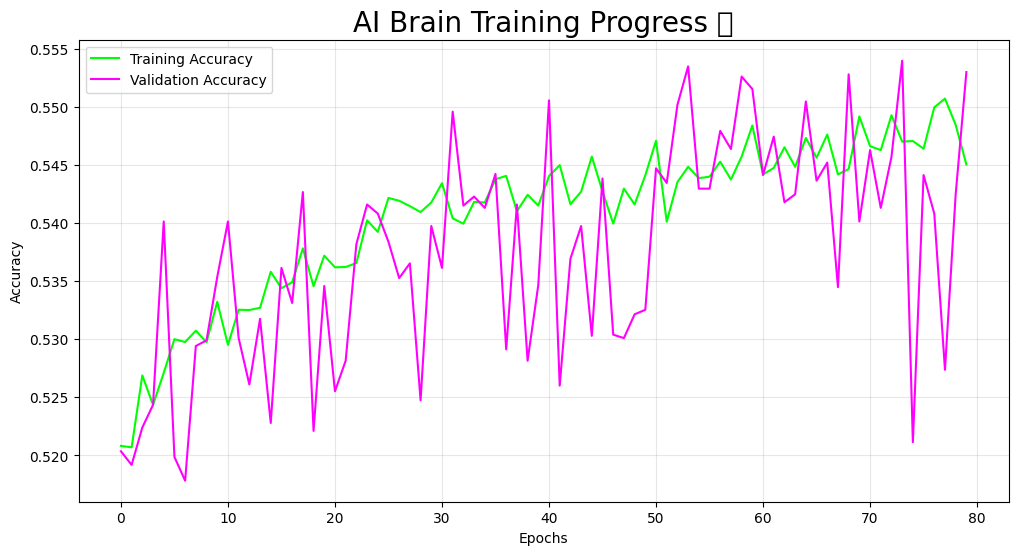

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy over time
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#00ff00')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff00ff')
plt.title('AI Brain Training Progress 🧠', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.style.use('dark_background') # Vibe aesthetic
plt.show()